In [1]:
! pip install unidecode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from unidecode import unidecode
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.1 MB/s eta 0:00:0000:01


# **[A. DATA CLEANING & DATA TRASFORMATION]**

# **I. Preprocessing `user_info` dataset**

In [2]:
# Read the CSV file at the specified path
path_info = r'/kaggle/input/dazone/user_info.csv'
path_log = r'/kaggle/input/dazone/user_log.csv'
user_info = pd.read_csv(path_info)
user_log = pd.read_csv(path_log)

# Display the first 5 rows of the DataFrame
user_info.head()

,user_id,age,sex,phone,job,carrier,marital_status
0,376517,44.0,gentle,******6654,Thực tập sinh giáo dục,other,Married
1,234512,39.0,lady,NaN,NaN,vietnamobile,Married
2,344532,39.0,she,******6296,DevOps Engineer,other,cưới
3,186135,37.0,she,******1502,Thực tập sinh giáo dục,vietnamobile,cưới
4,30230,38.0,female,******4966,DevOps Engineer,viettel,Married


In [3]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         424170 non-null  int64  
 1   age             328803 non-null  float64
 2   sex             418652 non-null  object 
 3   phone           402962 non-null  object 
 4   job             402962 non-null  object 
 5   carrier         402962 non-null  object 
 6   marital_status  423813 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 22.7+ MB


In [4]:
# Calculate the number and percentage% of missing (NaN) values in each column
missing_counts = user_info.isnull().sum()
missing_ratios = round(user_info.isnull().sum() / len(user_info) * 100, 4)

# Create a new DataFrame to display missing data statistics
missing_table = pd.DataFrame({
    'Variable': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing Ratio (%)': missing_ratios.values
})
print('user_info table')
missing_table

user_info table


,Variable,Missing Count,Missing Ratio (%)
0,user_id,0,0.0000
1,age,95367,22.4832
2,sex,5518,1.3009
3,phone,21208,4.9999
4,job,21208,4.9999
5,carrier,21208,4.9999
6,marital_status,357,0.0842


## **1.1. Preprocessing `age` column**

Since some ages are **negative (< 0) or greater than 100, which is unrealistic** for participants in the e-commerce platform, our team decided to replace these values with NaN.

In [5]:
# Validate that age is an integer greater than 0
tmp = user_info[(user_info['age'] <= 0) | (user_info['age'] > 100) | (user_info['age'] % 1 != 0)]
tmp.head()

,user_id,age,sex,phone,job,carrier,marital_status
28,171799,NaN,men,******0902,NaN,vietnamobile,ly hôn
103,32350,NaN,male,******1341,Y tá,vietnamobile,Divorced
132,210917,NaN,male,*****4773,Nhân viên lễ tân,mobiphone,ly hôn
144,38665,NaN,men,*****7182,Luật sư,vietnamobile,Married
146,115159,NaN,gentle,******2492,Chuyên viên bảo mật,mobiphone,Married


In [6]:
# Replace age is not an integer greater than 0 with NaN
user_info.loc[(user_info['age'] <= 0) | (user_info['age'] > 100) | (user_info['age'] % 1 != 0), 'age'] = np.nan

**BOXPLOT**

After performing verification, our team used a boxplot **to identify outliers (abnormal data)**, which helps in choosing appropriate data handling methods and avoiding bias in future analysis results.

count    327395.000000
mean         30.971731
std           8.066808
min          10.000000
25%          26.000000
50%          29.000000
75%          35.000000
max          77.000000
Name: age, dtype: float64
The lower whisker: 13.0
the upper whisker: 48.0


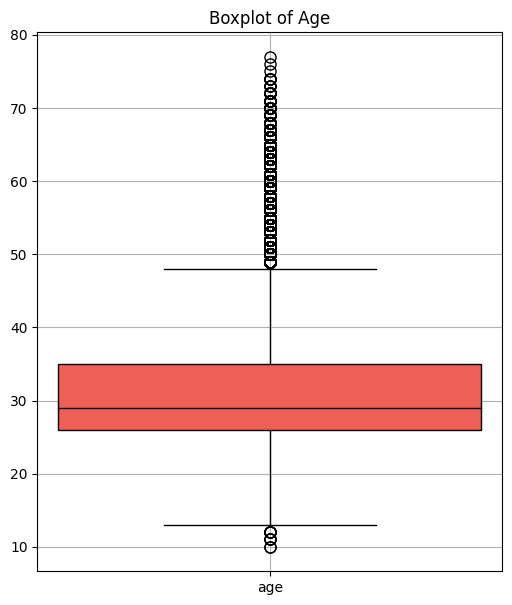

In [7]:
# Filter out rows where the 'age' column is NaN (missing values)
tmp = user_info[user_info['age'].notna()].copy()
# Display descriptive statistics of the 'age' column
print(tmp['age'].describe())

# Calculate Q1, Q3 & IQR (the interquartile range)
Q1 = tmp['age'].quantile(0.25)
Q3 = tmp['age'].quantile(0.75)
IQR = Q3 - Q1

# Determine the lower whisker & the upper whisker
whisker_lower = tmp['age'][tmp['age'] >= Q1 - 1.5 * IQR].min()
whisker_upper = tmp['age'][tmp['age'] <= Q3 + 1.5 * IQR].max()

# Print the calculated whisker values
print(f"The lower whisker: {whisker_lower}")
print(f"the upper whisker: {whisker_upper}")

# Create a new figure for the plot
plt.figure(figsize=(6, 7))
# Draw a boxplot of the 'age' column
box = tmp.boxplot(
        column='age',                 # Data to plot (ages)
        widths=6,                     # Width of Boxplot
        patch_artist=True,            # Set the thickness of the boxplot along the y-axis
        boxprops=dict(facecolor='#EE6055', edgecolor='#000000'),    # Customize box color and border
        whiskerprops=dict(color='#000000', linestyle='-'),          # Customize whisker color and line style
        capprops=dict(color='#000000'),                             # Customize the end caps of the whiskers
        medianprops=dict(color='#000000'),                          # Customize the median line
        flierprops=dict(marker='o', color='#FFA500', markersize=8)  # Customize outliers
    )

plt.title('Boxplot of Age')
plt.show()

According to the boxplot results, we categorized the dataset into two age groups for analysis:

- For ages between 13 and 48 (the lower whisker to the upper whisker), we will focus on an in-depth analysis of their behavior in this report.

- For ages from 10 to 12 and 49 to 77, we will conduct a preliminary analysis, but they will not be the main focus.

## **1.2. Preprocessing `sex` column**

After observation, our team found that the sex column contains many inconsistent values in terms of language, notation, and irregular Unicode encoding.

Therefore, in this section, we standardize the values by **grouping them into 'female' and 'male'**.

In [8]:
def normalize_unicode(text):
    if pd.isna(text):
        return text

    # Normalize unicode characters to a standard form (NFKC)
    text = unicodedata.normalize('NFKC', str(text))
    # Convert accented characters to their ASCII equivalents
    text = unidecode(text)
    # Return the text in lowercase and with leading/trailing whitespace removed
    return text.lower().strip()

def sex_mapping(value):
    if pd.isna(value):
        return np.nan

    # Define sets of keywords commonly used to indicate each gender
    female_keywords = {'lady', 'she', 'female', 'girl', 'woman', 'f'}
    male_keywords = {'gentle', 'male', 'm', 'boy', 'he', 'men'}
    unknown_keywords = {'unknown', 'other', 'snknown', 'nsll'}

    # Check which category the input value belongs to and return the standard label
    if value in female_keywords:
        return 'female'
    elif value in male_keywords:
        return 'male'
    elif value in unknown_keywords:
        return np.nan

In [9]:
# Show unique values in the 'sex' column before any processing
user_info['sex'].unique()

array(['gentle', 'lady', 'she', 'female', 'girl', 'male', 'M', nan, 'boy',
       'woman', 'F', 'he', 'men', 'unknown', 'other', 'mаle', 'mеn', 'hе',
       'malе', 'lаdy', 'wοman', 'fеmale', 'femаle', 'bοy', 'shе', 'gіrl',
       'womаn', 'gеntle', 'սnknown', 'femalе', 'gentlе', 'othеr', 'οther',
       'unknοwn', 'nսll', 'femаlе', 'fеmalе', 'wοmаn', 'mаlе', 'fеmаle',
       'gеntlе'], dtype=object)

In [10]:
# Step 1: Normalize unicode characters in the 'sex' column
# - Converts text to lowercase
# - Removes accents and diacritics
# - Strips leading/trailing whitespace
user_info['sex'] = user_info['sex'].apply(normalize_unicode)
user_info['sex'].unique()

array(['gentle', 'lady', 'she', 'female', 'girl', 'male', 'm', nan, 'boy',
       'woman', 'f', 'he', 'men', 'unknown', 'other', 'snknown', 'nsll'],
      dtype=object)

In [11]:
# Step 2: Map standardized values to 'male', 'female', or NaN
# - Converts values like 'm', 'boy', 'he' → 'male'
# - Converts values like 'f', 'lady', 'woman' → 'female'
# - Unrecognized or ambiguous values are set to NaN
user_info['sex'] = user_info['sex'].apply(sex_mapping)
user_info['sex'].unique()

array(['male', 'female', nan], dtype=object)

## **1.3. Preprocessing `phone` column**

To standardize the dataset, our team **converted missing values to NaN**.

In [12]:
# Replace missing values in 'phone' with the NaN
user_info['phone'] = user_info['phone'].fillna(np.nan)

## **1.4. Preprocessing `job` column**

Our team decided to **convert accented text to unaccented text** to standardize the data, reduce storage size, and prevent potential font-related errors in the future.

In [13]:
# Display the unique values in the 'job' column before normalization
user_info['job'].unique()

array(['Thực tập sinh giáo dục', nan, 'DevOps Engineer',
       'Kiến trúc sư phần mềm', 'UX/UI Designer',
       'Trưởng phòng kinh doanh', 'Lập trình viên',
       'Nhà phân tích dữ liệu', 'Y tá', 'Quản lý sản xuất',
       'Kỹ sư giám sát', 'Digital Marketer', 'Nghệ sĩ', 'Thực Tập',
       'Điều Dưỡng', 'Kiến trúc sư', 'Nông dân', 'Chuyên viên nhân sự',
       'Nhân viên kinh doanh', 'Nhân viên hành chính', 'Nhà báo',
       'Nhân viên nhà hàng', 'Bác sĩ', 'Chuyên viên tư vấn tuyển sinh',
       'Kỹ sư nông nghiệp', 'Thợ xây', 'Giảng viên',
       'Chuyên viên bảo mật', 'Kỹ sư xây dựng', 'Kỹ sư phần mềm',
       'Nhà thiết kế đồ họa', 'Project Manager', 'Nhà tư vấn tài chính',
       'Nhân viên khách sạn', 'Kiểm toán', 'Thư ký pháp lý',
       'Công nhân sản xuất', 'Nhân viên lễ tân', 'Chuyên viên tín dụng',
       'Giáo viên', 'Sales Representative', 'Tester', 'Kỹ sư sản xuất',
       'Biên dịch viên', 'Luật sư', 'Chuyên viên bán hàng trực tuyến',
       'Chuyên viên phân tích thị 

In [14]:
# Apply the 'normalize_unicode' function to each value in the 'job' column
user_info['job'] = user_info['job'].apply(normalize_unicode)
user_info['job'].unique()

array(['thuc tap sinh giao duc', nan, 'devops engineer',
       'kien truc su phan mem', 'ux/ui designer',
       'truong phong kinh doanh', 'lap trinh vien',
       'nha phan tich du lieu', 'y ta', 'quan ly san xuat',
       'ky su giam sat', 'digital marketer', 'nghe si', 'thuc tap',
       'dieu duong', 'kien truc su', 'nong dan', 'chuyen vien nhan su',
       'nhan vien kinh doanh', 'nhan vien hanh chinh', 'nha bao',
       'nhan vien nha hang', 'bac si', 'chuyen vien tu van tuyen sinh',
       'ky su nong nghiep', 'tho xay', 'giang vien',
       'chuyen vien bao mat', 'ky su xay dung', 'ky su phan mem',
       'nha thiet ke do hoa', 'project manager', 'nha tu van tai chinh',
       'nhan vien khach san', 'kiem toan', 'thu ky phap ly',
       'cong nhan san xuat', 'nhan vien le tan', 'chuyen vien tin dung',
       'giao vien', 'sales representative', 'tester', 'ky su san xuat',
       'bien dich vien', 'luat su', 'chuyen vien ban hang truc tuyen',
       'chuyen vien phan tich thi 

## **1.5. Preprocessing `carrier` column**

To standardize the dataset, our team **converted missing values to NaN**.

In [15]:
# Show all unique values in the 'carrier' column
user_info['carrier'].unique()

array(['other', 'vietnamobile', 'viettel', 'vinaphone', 'mobiphone', nan],
      dtype=object)

In [16]:
# Replace missing values in the 'carrier' column with np.nan explicitly
user_info['carrier'] = user_info['carrier'].fillna(np.nan)

## **1.6. Preprocessing `marital_status` column**

After observation, our team found that the marital_status column contains many inconsistent values in terms of language, notation, and irregular Unicode encoding.

Therefore, in this section, we standardize the values by **grouping them into 'married', 'single' and 'divorced'.**

In [17]:
def marital_status_mapping(value):
    if pd.isna(value):
        return np.nan

    # Define lists of keywords associated with each marital status
    married_keywords = ['Married', 'cưới']
    single_keywords = ['Unmarried', 'Single', 'độc thân']
    divorced_keywords = ['Divorced', 'ly hôn']

    # Check which group the value belongs to and return the corresponding standardized label
    if value in married_keywords:
        return 'married'
    elif value in single_keywords:
        return 'single'
    elif value in divorced_keywords:
        return 'divorced'

In [18]:
# Display all unique values in the 'marital_status' column before any processing
user_info['marital_status'].unique()

array(['Married', 'cưới', 'Single', 'ly hôn', 'Divorced', nan,
       'Unmarried', 'độc thân'], dtype=object)

In [19]:
# Apply the marital_status_mapping() function to standardize values in the column
user_info['marital_status'] = user_info['marital_status'].apply(marital_status_mapping)
user_info['marital_status'].unique()

array(['married', 'single', 'divorced', nan], dtype=object)

In [20]:
# Fill NaN temporarily with 'unknown' (object) and -1 (numerical) for analysis.
user_info['age'] = user_info['age'].fillna(-1)

numerical_cols = ['sex', 'phone', 'job', 'carrier', 'marital_status']
user_info[numerical_cols] = user_info[numerical_cols].fillna('unknown')

In [21]:
user_info

,user_id,age,sex,phone,job,carrier,marital_status
0,376517,44.0,male,******6654,thuc tap sinh giao duc,other,married
1,234512,39.0,female,unknown,unknown,vietnamobile,married
2,344532,39.0,female,******6296,devops engineer,other,married
3,186135,37.0,female,******1502,thuc tap sinh giao duc,vietnamobile,married
4,30230,38.0,female,******4966,devops engineer,viettel,married
...,...,...,...,...,...,...,...
424165,395814,26.0,male,******8563,kien truc su phan mem,vinaphone,married
424166,245950,-1.0,male,*****3449,tu van khach hang,other,divorced
424167,208016,-1.0,unknown,******7187,truong phong kinh doanh,viettel,married
424168,272535,45.0,male,*******0404,duoc si,vinaphone,married


## **1.7. Saving `user_info` in folder `cleaned_data`**

In [22]:
# Export the DataFrame user_info to a CSV file (without including the index column)
user_info.to_csv(r'/kaggle/working/cleaned_user_info.csv', index=False)

# **II. Preprocessing `user_log` dataset**

In [23]:
user_log.head()

,user_id,item_id,cat_id,brand_id,merchant_id,action,datetime
0,328862,323294,833,2661.0,2882,click,2024-08-29
1,328862,844400,1271,2661.0,2882,click,2024-08-29
2,328862,575153,1271,2661.0,2882,click,2024-08-29
3,328862,996875,1271,2661.0,2882,click,2024-08-29
4,328862,1086186,1271,1049.0,1253,click,2024-08-29


In [24]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   brand_id     float64
 4   merchant_id  int64  
 5   action       object 
 6   datetime     object 
dtypes: float64(1), int64(4), object(2)
memory usage: 2.9+ GB


In [25]:
missing_counts = user_log.isnull().sum()
missing_ratios = round(user_log.isnull().sum() / len(user_log) * 100, 4)

missing_table = pd.DataFrame({
    'Variable': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing Ratio (%)': missing_ratios.values
})
print('user_log table')
missing_table

user_log table


,Variable,Missing Count,Missing Ratio (%)
0,user_id,0,0.0000
1,item_id,0,0.0000
2,cat_id,0,0.0000
3,brand_id,91015,0.1657
4,merchant_id,0,0.0000
5,action,0,0.0000
6,datetime,0,0.0000


## **2.1. Preprocessing `datetime` column**

In [26]:
# Covert datetime 'object' to 'datetime'
user_log['datetime'] = pd.to_datetime(user_log['datetime'])

In [27]:
# Fill NaN temporarily with -1 for analysis.
user_log = user_log.fillna(-1)

## **2.2. Saving `user_log` in folder `cleaned_data`**

In [28]:
# Export the DataFrame user_log to a CSV file (without including the index column)
user_log.to_csv(r'/kaggle/working/cleaned_user_log.csv', index=False)

# **[B. ANALYST AND VISUALIZATION DATA]**

# **I. Visualization** #

**1.1. Univariate**

***1.1.1. `sex` column***

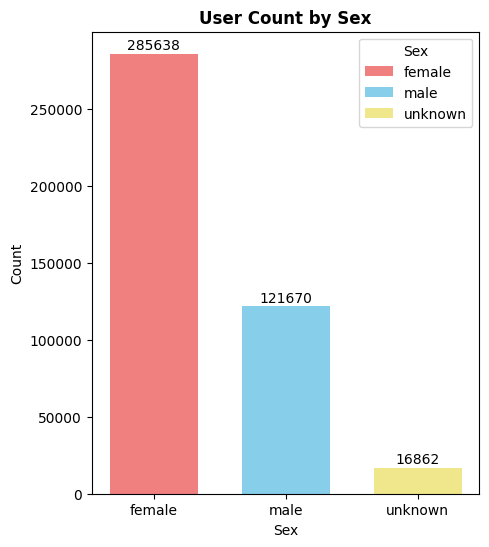

In [29]:
# Count the number of occurrences for each category in 'sex' column
sex_counts = user_info['sex'].value_counts()
labels = sex_counts.index
values = sex_counts.values

# Create positions for the bars, spacing them closely
x = np.arange(len(labels)) * 0.15

# Set the figure size
plt.figure(figsize=(5,6))
# Draw the bar chart
bars=plt.bar(
    x,
    values,
    color=['lightcoral', 'skyblue', 'khaki'], # khaki
    width=0.1        # Set the width of each bar (narrow bars close together)
)

# Add a legend to the plot
plt.legend(
    bars,            # Use the bar objects as handles for the legend
    labels,          # Use category labels for the legend text
    title="Sex",     # Title of the legend box
    loc="best"       # Automatically choose the best location for the legend
)

# Set the x-axis tick labels at bar positions
plt.xticks(x, labels)

plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('User Count by Sex', fontweight='bold')

# Add count text labels above each bar
for i, count in enumerate(values):
    plt.text(x[i], count + max(values)*0.01, str(count), ha='center')

plt.show()

***1.1.2. `age` column***

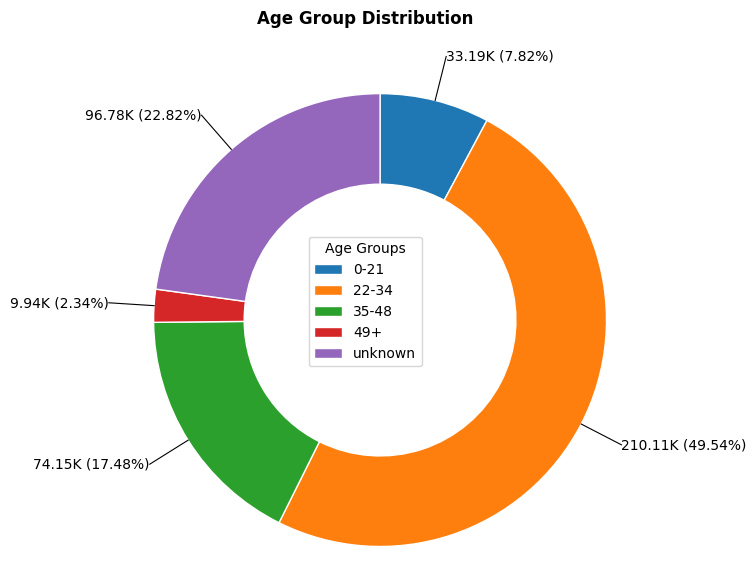

In [30]:
# Define age bins and corresponding labels
bins = [-100, 0, 22, 35, 49, 100]
labels = ['unknown', '0-21', '22-34', '35-48', '49+']

# Categorize ages into defined age groups with a specified order
user_info['age_group'] = pd.cut(
    user_info['age'],
    bins=bins,
    labels=pd.Categorical(labels, ordered=True),
    right=False)

# Count the number of users in each age group, preserving label order
age_counts = user_info['age_group'].value_counts(sort=False)

# Tính % và tạo label dạng "Số lượng (phần trăm%)"
total = age_counts.sum()
labels_with_values = [
    f'{count/1000:.2f}K ({count/total:.2%})' for count in age_counts
]

# Vẽ pie chart
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts = ax.pie(
    age_counts,
    startangle=90,
    counterclock=False,
    wedgeprops=dict(width=0.4, edgecolor='w')
)

outer_radius = 1  # bán kính ngoài của miếng pie (mặc định là 1.0)
# Thêm đường leader lines và label ở ngoài
for i, (wedge, label) in enumerate(zip(wedges, labels_with_values)):
    angle = (wedge.theta2 + wedge.theta1) / 2
    angle_rad = np.deg2rad(angle)

    x_start = outer_radius * np.cos(np.deg2rad(angle))
    y_start = outer_radius * np.sin(np.deg2rad(angle))

    x_end = 1.2 * outer_radius * np.cos(np.deg2rad(angle))
    y_end = 1.2 * outer_radius * np.sin(np.deg2rad(angle))

    # Vị trí đặt label (xa hơn tí)
    x_label = 1.35 * np.cos(angle_rad)
    y_label = 1.35 * np.sin(angle_rad)
    ha = 'left' if x_label >= 0 else 'right'

    ax.plot([x_start, x_end], [y_start, y_end], color='black', lw=0.8)  # Line từ mép ngoài đến label
    ax.text(x_end, y_end, label, ha=ha, va='center')

# Thêm chú thích
ax.legend(
    wedges,
    age_counts.index,
    title="Age Groups",
    loc="center"
)

ax.set_title('Age Group Distribution', fontweight='bold')
ax.axis('equal')
plt.show()

***1.1.3. `job` column***

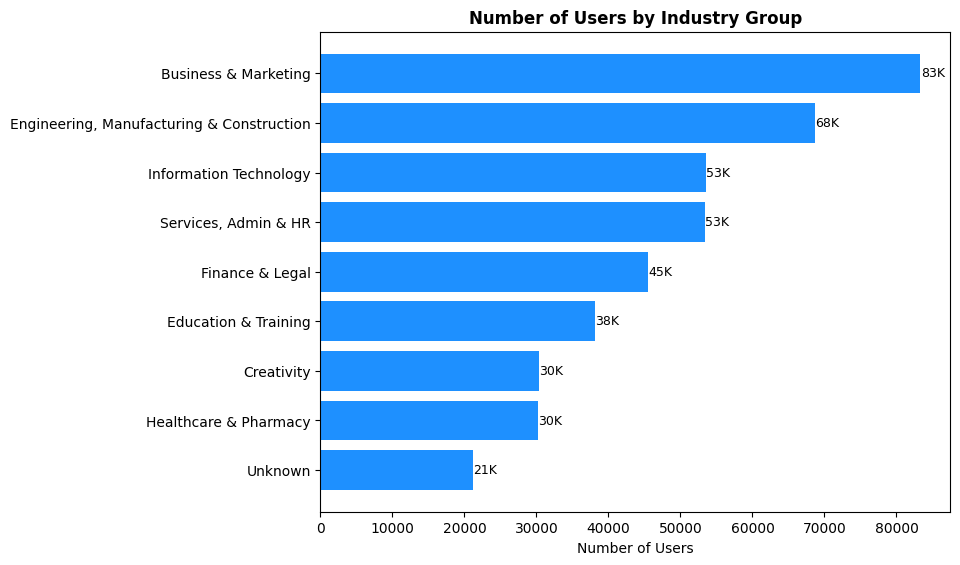

In [31]:
# Define a function to classify job titles into industry groups
def classify_job(job):
    if job in ["lap trinh vien", "devops engineer", "kien truc su phan mem", "ux/ui designer", "ky su phan mem", "chuyen vien bao mat", "tester"]:
        return "Information Technology"
    elif job in ["nhan vien kinh doanh", "truong phong kinh doanh", "giam doc kinh doanh", "marketing manager", "digital marketer", "chuyen vien ban hang truc tuyen", "sales representative", "chuyen vien phan tich thi truong", "nhan vien ban hang", "nhan vien ngan hang", "nha phan tich du lieu"]:
        return "Business & Marketing"
    elif job in ["giao vien", "giang vien", "thuc tap sinh giao duc", "chuyen vien tu van tuyen sinh", "thuc tap"]:
        return "Education & Training"
    elif job in ["bac si", "y ta", "dieu duong", "duoc si"]:
        return "Healthcare & Pharmacy"
    elif job in ["kiem toan", "ke toan", "luat su", "nha tu van tai chinh", "chuyen vien tin dung", "thu ky phap ly"]:
        return "Finance & Legal"
    elif job in ["ky su giam sat", "ky su xay dung", "ky su san xuat", "ky su nong nghiep", "cong nhan san xuat", "tho xay", "quan ly san xuat", "kien truc su", "nong dan"]:
        return "Engineering, Manufacturing & Construction"
    elif job in ["nhan vien nha hang", "nhan vien khach san", "nhan vien le tan", "nhan vien hanh chinh", "chuyen vien nhan su", "tu van khach hang", "bien dich vien"]:
        return "Services, Admin & HR"
    elif job in ["nghe si", "nha bao", "nha thiet ke do hoa", "project manager"]:
        return "Creativity"
    else:
        return "Unknown"

# Apply the classification function to each user's job title
user_info['job_group'] = user_info['job'].apply(classify_job)
counts = user_info['job_group'].value_counts()

# Draw bar chart
plt.figure(figsize=(9, 6))
bars = plt.barh(counts.index, counts.values, color='dodgerblue', height=0.8)

# Invert the Y-axis so the top category appears at the top
plt.gca().invert_yaxis()
plt.title('Number of Users by Industry Group', fontsize=12, fontweight='bold')
plt.xlabel('Number of Users', fontsize=10)

# Add data labels
for bar in bars:
    value = int(bar.get_width())
    label = f'{value//1000}K' if value >= 1000 else str(value)
    plt.text(value + 50, bar.get_y() + bar.get_height()/2, label, va='center', fontsize=9)

# Optimize spacing so labels and title
plt.tight_layout()
plt.subplots_adjust(top=1, bottom=0.2, left=0.25, right=0.95)

plt.show()



***1.1.4. `marital_status` column***

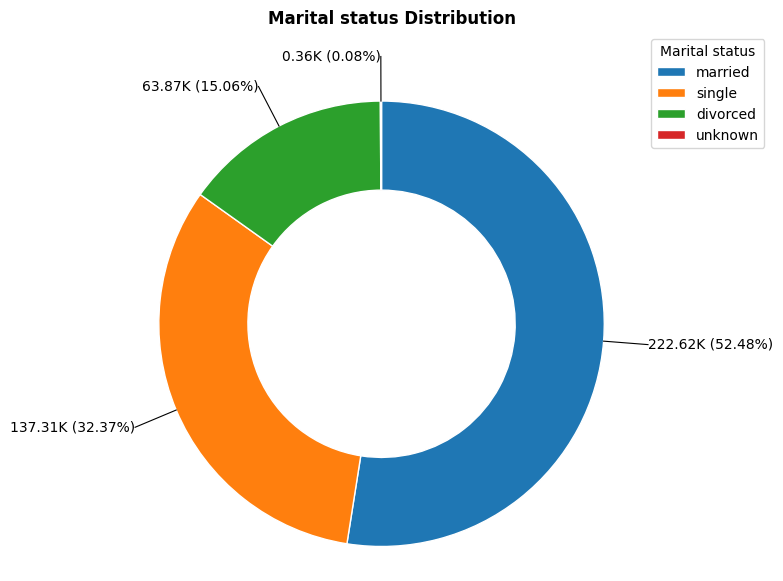

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Count the number of users per marital status (no grouping)
status_counts = user_info['marital_status'].value_counts()

# Total users for percentage calculation
total = status_counts.sum()

# Create labels in the format: "Count (Percentage%)"
labels_with_values = [
    f'{count/1000:.2f}K ({count/total:.2%})' for count in status_counts
]

# Draw pie chart
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts = ax.pie(
    status_counts,
    startangle=90,
    counterclock=False,
    wedgeprops=dict(width=0.4, edgecolor='w')
)

# Outer radius of the donut
outer_radius = 1

# Add leader lines and value labels
for i, (wedge, label) in enumerate(zip(wedges, labels_with_values)):

    # Midpoint angle of each wedge
    angle = (wedge.theta2 + wedge.theta1) / 2
    angle_rad = np.deg2rad(angle)

    # Start and end of leader line
    x_start = outer_radius * np.cos(angle_rad)
    y_start = outer_radius * np.sin(angle_rad)

    x_end = 1.2 * outer_radius * np.cos(angle_rad)
    y_end = 1.2 * outer_radius * np.sin(angle_rad)

    # Label position
    x_label = 1.35 * np.cos(angle_rad)
    y_label = 1.35 * np.sin(angle_rad)

    # Text alignment
    ha = 'left' if x_label >= 0 else 'right'

    # Draw leader line
    ax.plot([x_start, x_end], [y_start, y_end], color='black', lw=0.8)

    # Place text label
    ax.text(x_end, y_end, label, ha=ha, va='center')

# Legend using marital status labels
ax.legend(
    wedges,
    status_counts.index,
    title="Marital status",
    loc='upper right',
    bbox_to_anchor=(1.2, 1)
)

# Chart title and equal aspect ratio
ax.set_title('Marital status Distribution', fontweight='bold')
ax.axis('equal')
plt.show()


***1.1.5. `carrier` column***

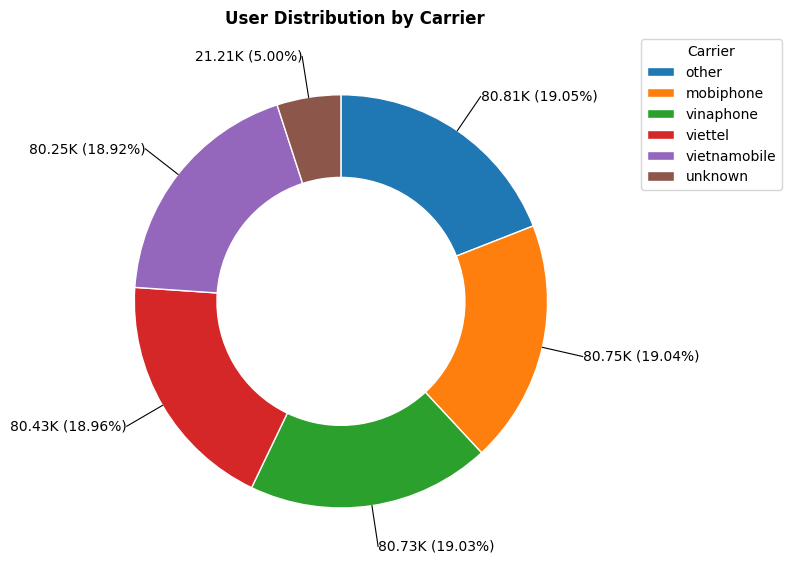

In [33]:
# Count number of users per carrier
carrier_counts = user_info['carrier'].value_counts()

# Total for percentage calculation
total = carrier_counts.sum()

# Format: "Count (Percentage%)"
labels_with_values = [
    f'{count/1000:.2f}K ({count/total:.2%})' for count in carrier_counts
]

# Pie chart setup
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts = ax.pie(
    carrier_counts,
    startangle=90,
    counterclock=False,
    wedgeprops=dict(width=0.4, edgecolor='w')
)

# Radius for lines and label positioning
outer_radius = 1

# Draw leader lines and external labels
for wedge, label in zip(wedges, labels_with_values):
    angle = (wedge.theta2 + wedge.theta1) / 2
    angle_rad = np.deg2rad(angle)

    x_start = outer_radius * np.cos(angle_rad)
    y_start = outer_radius * np.sin(angle_rad)

    x_end = 1.2 * outer_radius * np.cos(angle_rad)
    y_end = 1.2 * outer_radius * np.sin(angle_rad)

    x_label = 1.35 * np.cos(angle_rad)
    y_label = 1.35 * np.sin(angle_rad)

    ha = 'left' if x_label >= 0 else 'right'

    ax.plot([x_start, x_end], [y_start, y_end], color='black', lw=0.8)
    ax.text(x_end, y_end, label, ha=ha, va='center')

# Legend using carrier labels
ax.legend(
    wedges,
    carrier_counts.index,
    title="Carrier",
    loc='upper right',
    bbox_to_anchor=(1.3, 1)
)

# Title & layout polish
ax.set_title('User Distribution by Carrier', fontweight='bold')
ax.axis('equal')
plt.show()

**1.2. Multivariate**

### **Customer characteristics**

***1.2.1 `age` & `sex`***

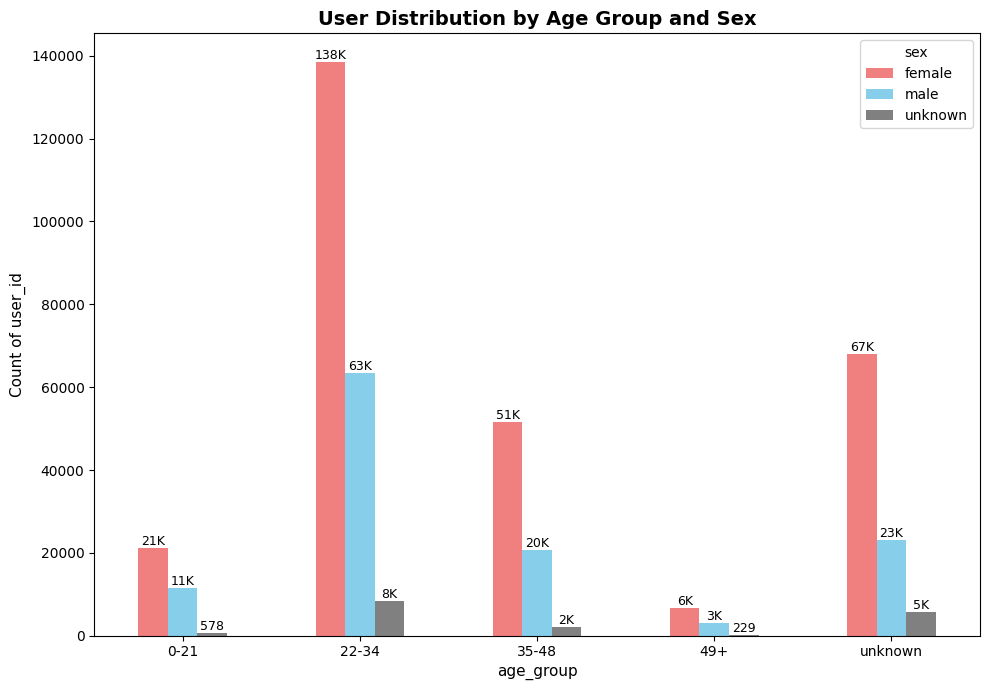

In [34]:
# Count number of users per age group and sex
count_data = user_info.groupby(['age_group', 'sex'])['user_id'].count().reset_index()

# Format counts in thousands for display (e.g. 138K)
count_data['label'] = count_data['user_id'].apply(lambda x: f'{x//1000}K')

# Pivot for plotting
pivot_data = count_data.pivot(index='age_group', columns='sex', values='user_id').fillna(0)

# Set up colors
color_map = {'female': 'lightcoral', 'male': 'skyblue'}

# Plot
ax = pivot_data.plot(kind='bar', figsize=(10, 7), color=[color_map.get(x, 'gray') for x in pivot_data.columns])

# Add text labels on top of each bar segment
for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(val)//1000}K' if val >= 1000 else f'{int(val)}' for val in container.datavalues], label_type='edge', fontsize=9)

# Styling
plt.title('User Distribution by Age Group and Sex', fontsize=14, fontweight='bold')
plt.xlabel('age_group', fontsize=11)
plt.ylabel('Count of user_id', fontsize=11)
plt.xticks(rotation=0)
plt.legend(title='sex')
plt.tight_layout()
plt.show()


***1.2.2. `age` & `marital_status`***

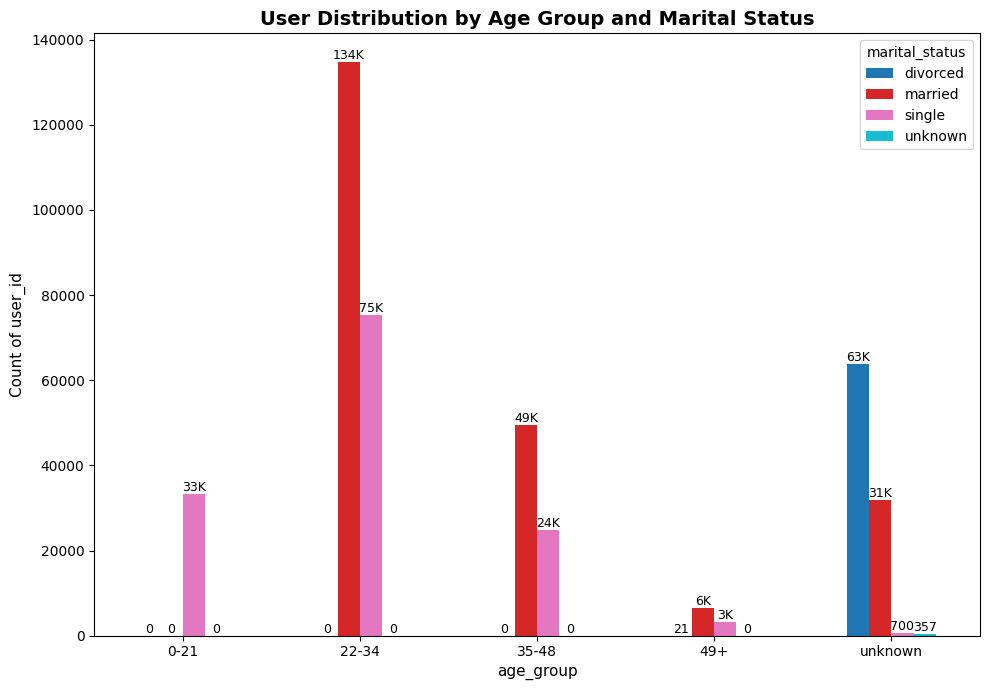

In [35]:
# Count number of users per age group and marital_status
count_data = user_info.groupby(['age_group', 'marital_status'])['user_id'].count().reset_index()

# Create label like "138K"
count_data['label'] = count_data['user_id'].apply(lambda x: f'{x//1000}K' if x >= 1000 else str(x))

# Pivot for plotting
pivot_data = count_data.pivot(index='age_group', columns='marital_status', values='user_id').fillna(0)

# Assign colors automatically or manually
colors = plt.cm.get_cmap('tab10', len(pivot_data.columns)).colors

# Plot
ax = pivot_data.plot(kind='bar', figsize=(10, 7), color=colors)

# Add labels on each bar
for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(val)//1000}K' if val >= 1000 else str(int(val)) for val in container.datavalues],
                 label_type='edge', fontsize=9)

# Styling
plt.title('User Distribution by Age Group and Marital Status', fontsize=14, fontweight='bold')
plt.xlabel('age_group', fontsize=11)
plt.ylabel('Count of user_id', fontsize=11)
plt.xticks(rotation=0)
plt.legend(title='marital_status')
plt.tight_layout()
plt.show()

***1.2.3. `marital_status` & `sex`***

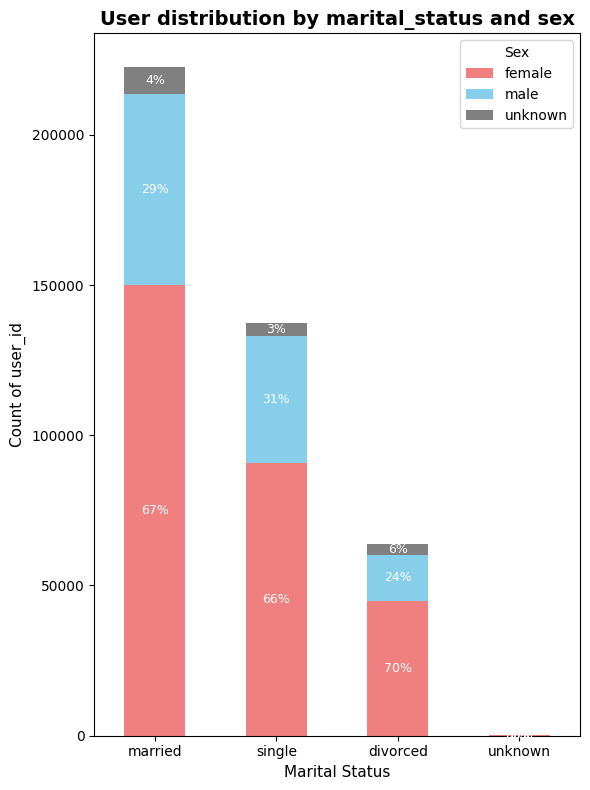

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Group by marital_status and sex, count user_id
count_data = user_info.groupby(['marital_status', 'sex'])['user_id'].count().reset_index()

# Step 2: Pivot to wide format
pivot_data = count_data.pivot(index='marital_status', columns='sex', values='user_id').fillna(0)

# Step 3: Sort by total count (descending)
pivot_data['total'] = pivot_data.sum(axis=1)
pivot_data = pivot_data.sort_values(by='total', ascending=False).drop(columns='total')

# Step 4: Compute percentage by row (within marital_status group)
pivot_percent = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Step 5: Plot the stacked bar chart (using count for height)
colors = {'female': 'lightcoral', 'male': 'skyblue'}
ax = pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(6, 8),
    color=[colors.get(col, '#808080') for col in pivot_data.columns]
)

# Step 6: Add percentage labels from pivot_percent
for i, container in enumerate(ax.containers):
    sex_label = pivot_data.columns[i]
    for bar, percent in zip(container, pivot_percent[sex_label]):
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f'{percent:.0f}%',
                ha='center',
                va='center',
                fontsize=9,
                color='white'
            )

# Step 7: Final chart styling
plt.title('User distribution by marital_status and sex', fontsize=14, fontweight='bold')
plt.xlabel('Marital Status', fontsize=11)
plt.ylabel('Count of user_id', fontsize=11)
plt.xticks(rotation=0)
plt.legend(title='Sex')
plt.tight_layout()
plt.show()


### **Behavioral characteristics**

***1.2.4. `user_id` & `datetime`***

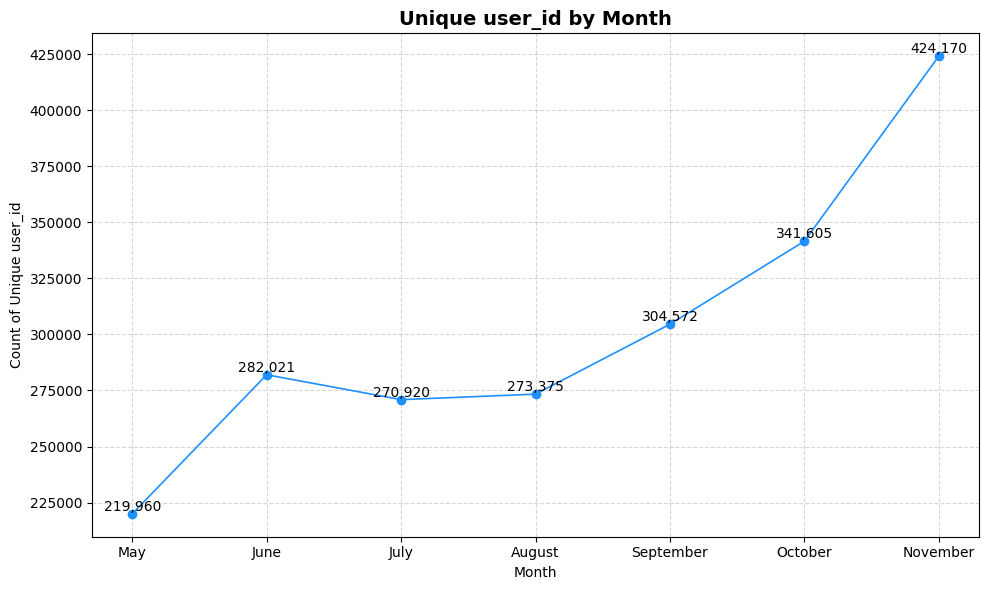

In [37]:
user_log.columns = user_log.columns.str.strip().str.lower()

# Convert 'datetime' column to datetime format and extract month names
user_log['datetime'] = pd.to_datetime(user_log['datetime'])
user_log['month'] = user_log['datetime'].dt.strftime('%B')

# Count unique users by month
monthly_users = user_log.groupby('month')['user_id'].nunique()

# Ensure the months are in correct order
month_order = ['May', 'June', 'July', 'August', 'September', 'October', 'November']  # Define desired month order
monthly_users = monthly_users.reindex(month_order)                                   # Reorder rows to match month_order

# Plot the line chart
plt.figure(figsize=(10, 6))                                                          # Set the size of the plot
plt.plot(monthly_users.index, monthly_users.values, marker='o', linewidth=1.2, color='dodgerblue')  # Draw the line chart

# Add value labels to each point
for x, y in zip(monthly_users.index, monthly_users.values):
    plt.text(x, y, f'{y:,}', ha='center', va='bottom', fontsize=10)   # Show formatted number at each point

plt.title('Unique user_id by Month', fontsize=14, fontweight='bold')  # Set the chart title
plt.xlabel('Month')                                                   # Set x-axis label
plt.ylabel('Count of Unique user_id')                                 # Set y-axis label
plt.grid(True, linestyle='--', alpha=0.5)                             # Add dashed grid lines for better readability
plt.tight_layout()                                                    # Adjust layout to fit all elements
plt.show()                                                            # Display the chart

***1.2.5. `user_id` & `datetime` & `action`***

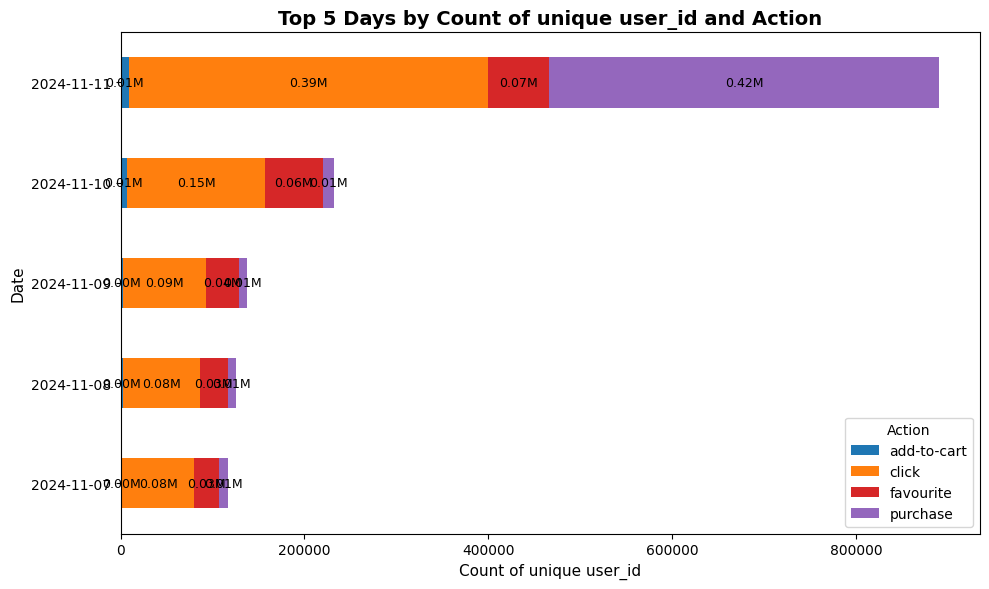

In [69]:
user_log['datetime'] = pd.to_datetime(user_log['datetime']).dt.date

# Step 1: Count unique user_id by date and action type
grouped = user_log.groupby(['datetime', 'action'])['user_id'].nunique().reset_index()

# Step 2: Create pivot table
pivot_data = grouped.pivot(index='datetime', columns='action', values='user_id').fillna(0)

# Step 3: Ensure correct column order based on desired actions (if present)
ordered_actions = ['add-to-cart', 'click', 'favourite', 'purchase']
pivot_data = pivot_data[[col for col in ordered_actions if col in pivot_data.columns]]

# Step 4: Sort by total unique user_id counts (descending) and take top 5 days
pivot_data['total'] = pivot_data.sum(axis=1)
pivot_data = pivot_data.sort_values(by='total', ascending=True).tail(5).drop(columns='total') 

# Step 5: Calculate percentage per row (optional, kept for compatibility)
pivot_percent = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Step 6: Plot horizontal stacked bar chart
colors = {
    'add-to-cart': '#1f77b4',   # Blue
    'click': '#ff7f0e',         # Orange
    'favourite': '#d62728',     # Red
    'purchase': '#9467bd'       # Purple
}

ax = pivot_data.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    color=[colors.get(col, '#808080') for col in pivot_data.columns]
)

# Step 7: Add count labels to each bar segment
for i, action in enumerate(pivot_data.columns):
    for bar, count in zip(ax.containers[i], pivot_data[action]):
        width = bar.get_width()
        if width > 0:
            ax.text(
                bar.get_x() + width / 2,
                bar.get_y() + bar.get_height() / 2,
                f'{count/1_000_000:.2f}M', 
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )

# Step 8: Customize the chart
plt.title('Top 5 Days by Count of unique user_id and Action', fontsize=14, fontweight='bold')  # Updated title
plt.xlabel('Count of unique user_id', fontsize=11)  # Updated x-label
plt.ylabel('Date', fontsize=11)
plt.legend(title='Action')
ax.set_yticklabels(pivot_data.index)
plt.tight_layout()
plt.show()

***1.2.6. Distribution Chart of Number of Active Days per User***

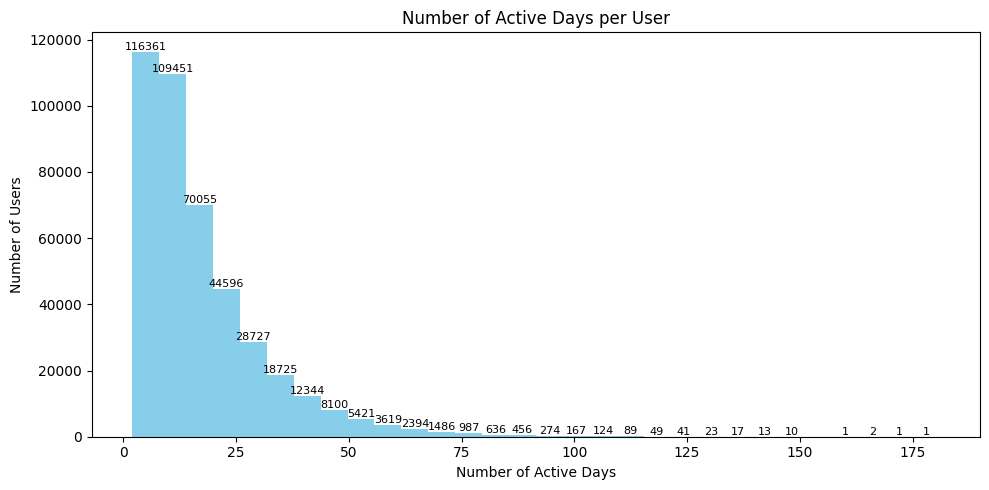

In [62]:
# Step 1: Count the number of unique active days for each user
user_freq = user_log.groupby('user_id')['datetime'].nunique().reset_index()
user_freq.columns = ['user_id', 'active_days']

# Step 2: Create histogram data with 30 bins
counts, bins = np.histogram(user_freq['active_days'], bins=30)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Step 3: Plot the bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(bin_centers, counts, width=(bins[1] - bins[0]), color='skyblue')

# Step 4: Add data labels on top of each bar
for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(int(height)), 
                 ha='center', va='bottom', fontsize=8)

# Step 5: Customize the chart
plt.title("Number of Active Days per User")
plt.xlabel("Number of Active Days")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

***1.2.7. Ratio of Deal-Hunter vs Loyal Users***

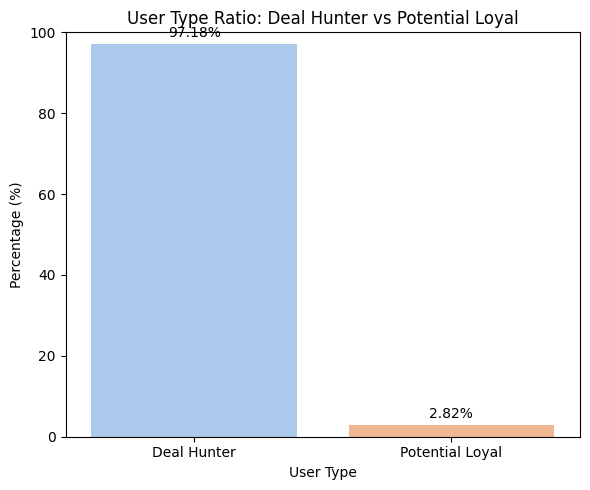

In [63]:
# Step 1: Classify users based on number of active days
user_freq['user_type'] = user_freq['active_days'].apply(lambda x: 'Deal Hunter' if x < 54 else 'Potential Loyal')

# Step 2: Count number of users in each category
type_counts = user_freq['user_type'].value_counts().reset_index()
type_counts.columns = ['user_type', 'count']
type_counts['percent'] = (type_counts['count'] / type_counts['count'].sum() * 100).round(2)

# Step 3: Plot the percentage of each user type
plt.figure(figsize=(6, 5))
bars = sns.barplot(x='user_type', y='percent', data=type_counts, palette='pastel')

# Step 4: Add percentage labels on top of each bar
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 1,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=10)

# Step 5: Customize the chart
plt.title("User Type Ratio: Deal Hunter vs Potential Loyal")
plt.ylabel("Percentage (%)")
plt.xlabel("User Type")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

***1.2.8. Distribution Chart of Users by Their Average Number of Interactions per Merchant***

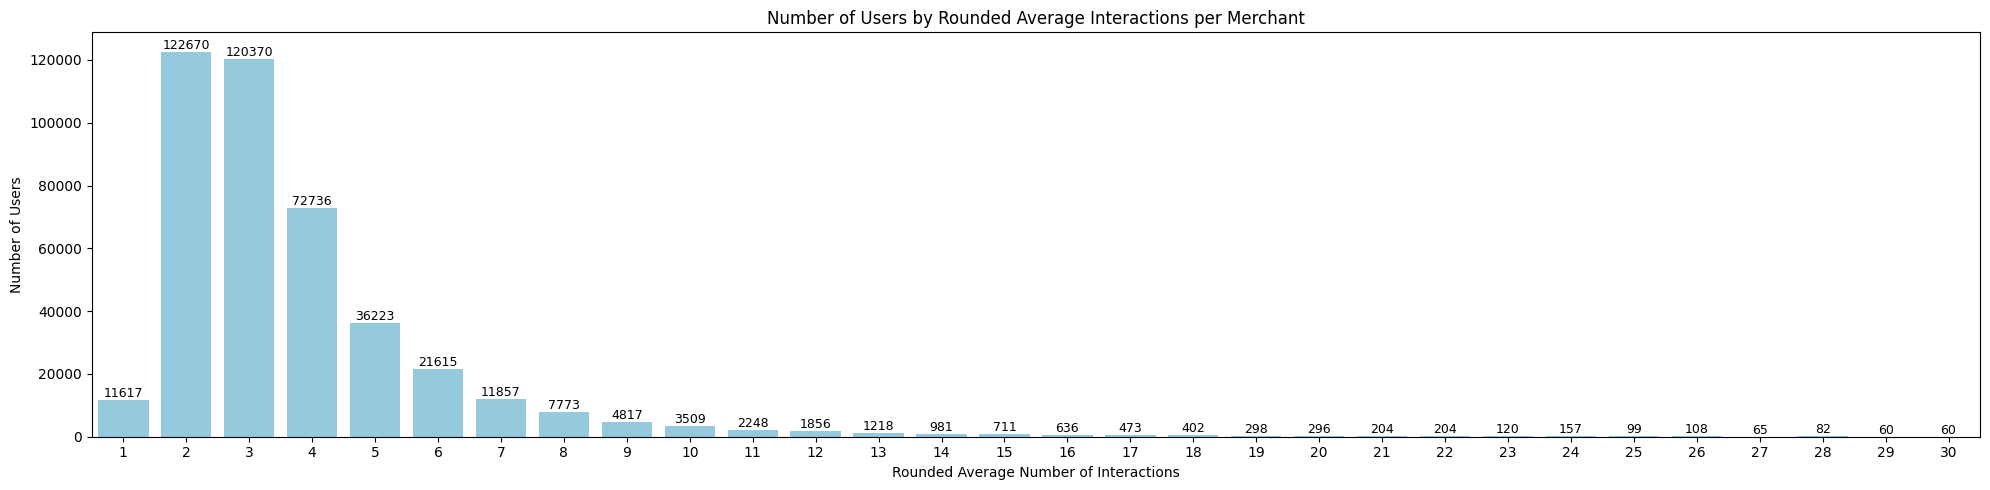

In [64]:
# Step 1: Count number of interactions between each user and each merchant
merchant_loyalty = user_log.groupby(['user_id', 'merchant_id']).size().reset_index(name='interactions')

# Step 2: Calculate average number of interactions per user (across all merchants)
user_avg_interactions = merchant_loyalty.groupby('user_id')['interactions'].mean().reset_index(name='avg_interactions')

# Step 3: Round to nearest integer (use np.floor for stricter threshold if needed)
user_avg_interactions['avg_interactions_int'] = user_avg_interactions['avg_interactions'].round().astype(int)

# Step 4: Count number of users for each average interaction level
interaction_distribution = user_avg_interactions['avg_interactions_int'].value_counts().sort_index()

# Step 5: Limit to average interaction values less than or equal to 30
interaction_distribution = interaction_distribution[interaction_distribution.index <= 30]

# Step 6: Plot bar chart
plt.figure(figsize=(20, 5))
ax = sns.barplot(x=interaction_distribution.index, y=interaction_distribution.values, color='skyblue')
plt.title("Number of Users by Rounded Average Interactions per Merchant")
plt.xlabel("Rounded Average Number of Interactions")
plt.ylabel("Number of Users")

# Step 7: Add labels on top of each bar
for i, value in enumerate(interaction_distribution.values):
    ax.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [66]:
def label_user_loyalty(x):
    if x < 15:
        return 'Deal Hunter'
    else:
        return 'Potential Loyal'

merchant_loyalty['loyalty_group'] = merchant_loyalty['interactions'].apply(label_user_loyalty)

***1.2.9. Tỉ lệ người dùng deal hunter vs loyal***

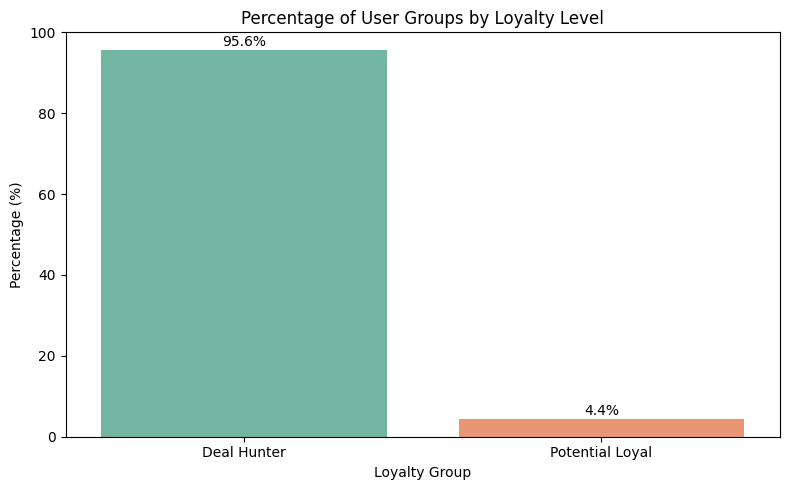

In [67]:
# Step 1: Count the number of users in each loyalty group
group_counts = merchant_loyalty['loyalty_group'].value_counts().reset_index()
group_counts.columns = ['Loyalty Group', 'Count']

# Step 2: Calculate percentages
group_counts['Percent'] = 100 * group_counts['Count'] / group_counts['Count'].sum()

# Step 3: Plot the bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=group_counts, x='Loyalty Group', y='Percent', palette='Set2')
plt.title('Percentage of User Groups by Loyalty Level')
plt.ylabel('Percentage (%)')
plt.xlabel('Loyalty Group')
plt.ylim(0, 100)

# Step 4: Add percentage labels on top of each bar
for index, row in group_counts.iterrows():
    plt.text(index, row['Percent'] + 1, f"{row['Percent']:.1f}%", ha='center')
plt.tight_layout()
plt.show()

# **Prepare data for modeling**

## **Prepare user_info**

In [44]:
cleaned_user_info = pd.read_csv(r'/kaggle/working/cleaned_user_info.csv')
cleaned_user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         424170 non-null  int64  
 1   age             424170 non-null  float64
 2   sex             424170 non-null  object 
 3   phone           424170 non-null  object 
 4   job             424170 non-null  object 
 5   carrier         424170 non-null  object 
 6   marital_status  424170 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 22.7+ MB


In [45]:
# Drop column have unique values
cleaned_user_info.drop(columns=['phone'], inplace=True)
# Replace -1 with median in 'age' column, astype to int
cleaned_user_info['age'] = cleaned_user_info['age'].replace(-1, cleaned_user_info['age'].median())
# Convert 'age' column to int
cleaned_user_info['age'] = cleaned_user_info['age'].astype(int)

In [46]:
categorical_columns = ['sex', 'job', 'carrier', 'marital_status'] 

label_encoder = LabelEncoder()

for column in categorical_columns:
    # Replace 'unknown' with mode of the column
    cleaned_user_info[column] = cleaned_user_info[column].replace('unknown', cleaned_user_info[column].mode()[0])
    # Convert to category type
    cleaned_user_info[column] = cleaned_user_info[column].astype('category')
    # Encode categorical columns
    cleaned_user_info[column] = label_encoder.fit_transform(cleaned_user_info[column])

cleaned_user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   user_id         424170 non-null  int64
 1   age             424170 non-null  int64
 2   sex             424170 non-null  int64
 3   job             424170 non-null  int64
 4   carrier         424170 non-null  int64
 5   marital_status  424170 non-null  int64
dtypes: int64(6)
memory usage: 19.4 MB


In [47]:
cleaned_user_info.to_csv(r'/kaggle/working/filled_user_info.csv', index=False)

## **Prepare user_log**

In [48]:
cleaned_user_log = pd.read_csv('/kaggle/working/cleaned_user_log.csv')
cleaned_user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   brand_id     float64
 4   merchant_id  int64  
 5   action       object 
 6   datetime     object 
dtypes: float64(1), int64(4), object(2)
memory usage: 2.9+ GB


In [49]:
tmp = cleaned_user_log.copy()
tmp = tmp[tmp['action'] == 'purchase']
columns = ['user_id', 'item_id', 'cat_id', 'brand_id', 'merchant_id']
tmp = tmp[columns]
tmp = tmp.drop_duplicates()
tmp = tmp.drop(tmp.sample(frac=0.998, random_state=42).index) 
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5880 entries, 1518 to 54922794
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      5880 non-null   int64  
 1   item_id      5880 non-null   int64  
 2   cat_id       5880 non-null   int64  
 3   brand_id     5880 non-null   float64
 4   merchant_id  5880 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 275.6 KB


In [50]:
train = tmp[tmp['brand_id'] != -1]
predict = cleaned_user_log[cleaned_user_log['brand_id'] == -1]

# Lấy danh sách các cột đặc trưng để huấn luyện
features = train.drop('brand_id', axis=1).columns.intersection(predict.columns)

# Huấn luyện mô hình
model = RandomForestClassifier()
model.fit(train[features], train['brand_id'])

# Dự đoán và gán lại giá trị
cleaned_user_log.loc[cleaned_user_log['brand_id'] == -1, 'brand_id'] = model.predict(predict[features])

In [51]:
cleaned_user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   brand_id     float64
 4   merchant_id  int64  
 5   action       object 
 6   datetime     object 
dtypes: float64(1), int64(4), object(2)
memory usage: 2.9+ GB


In [52]:
cleaned_user_log.to_csv('/kaggle/working/filled_user_log.csv', index=False)

# **Prepare train**

***Drop all missing and duplicates***

In [53]:
train = pd.read_csv(r'/kaggle/input/dazone/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233782 entries, 0 to 233781
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      228192 non-null  float64
 1   merchant_id  228284 non-null  float64
 2   label        233782 non-null  float64
dtypes: float64(3)
memory usage: 5.4 MB


In [54]:
train = train.dropna().drop_duplicates()

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215555 entries, 0 to 233779
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      215555 non-null  float64
 1   merchant_id  215555 non-null  float64
 2   label        215555 non-null  float64
dtypes: float64(3)
memory usage: 6.6 MB


In [56]:
train.to_csv('/kaggle/working/train.csv', index=False)

# **Prepare test**

***Drop all missing and duplicates***

In [57]:
test = pd.read_csv(r'/kaggle/input/dazone/test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52695 entries, 0 to 52694
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      52695 non-null  int64
 1   merchant_id  52695 non-null  int64
 2   label        52695 non-null  int64
dtypes: int64(3)
memory usage: 1.2 MB


In [58]:
test = test.dropna().drop_duplicates()

In [59]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52695 entries, 0 to 52694
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      52695 non-null  int64
 1   merchant_id  52695 non-null  int64
 2   label        52695 non-null  int64
dtypes: int64(3)
memory usage: 1.2 MB


In [60]:
test.to_csv('/kaggle/working/test.csv', index=False)